# Analyze Seattle Airbnb Data

Analyzing Seattle Airbnb data by answering three questions:
<br>
1. Are hosts who have a high review score rating charging renters more?
2. What are the pricing trends in Seattle?
3. What are the 3 most expensive and least expensive neighbourhoods in Seattle for renting?

In [884]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcdefaults()

listings_df = pd.read_csv('seattle/listings.csv')

### Question: Are hosts who have a high review score rating charging renters more?

Figure out if Hosts, with higher review rating score, are charging renters a higher price.
<br><br>
Since we need to do a price comparison between listings, we need a way to calculate a price value irrespective of the number of bedrooms, bathrooms etc. One way to do that would be to calculate price per accommodation. The data offers information on price and accommodation, therefore we'll create a new columns 'price_per_accommodation' and fill it with price/accommodation.
<br><br>
The 'price' column in this dataset needs to be formatted first by removing the '$' sign, commas, and converting it into a float. I'll create a new column 'price_val' which does this for us.

In [885]:
# Format 'price' of a DataFrame and create a new column 'price_val'
def format_price(df):
    
    # remove $ sign
    df['price_val'] = df['price'].str[1:]

    # remove commas
    df['price_val'] = df['price_val'].str.replace(',', '')

    # convert to numeric
    df['price_val'] = pd.to_numeric(df['price_val'])

In [886]:
format_price(listings_df)

In [887]:
# Calculate price per accomnodation for each listing
listings_df['price_per_accommodation'] = listings_df['price_val'] / listings_df['accommodates']

Now let's look at the 'review_scores_value' data.

In [888]:
listings_df['review_scores_value'].value_counts()

10.0    1775
9.0     1137
8.0      190
7.0       38
6.0       16
4.0        4
5.0        1
2.0        1
Name: review_scores_value, dtype: int64

Looks like reviews are given on a 1-10 scale and most of the Hosts have received review scores of 7 or higher. We'll drop reviews below 7 since we don't have enough data for them. Our analysis will be for the following review scores: 7, 8, 9, 10.

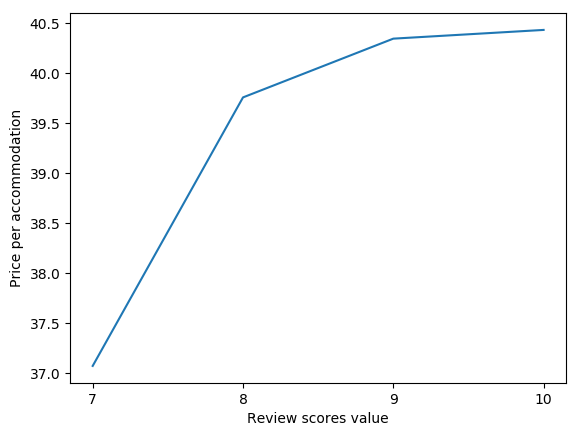

In [889]:
def get_prices_for_review_score(df):
    prices = np.zeros(4)
    
    for i in range(4):
        review_score = 7 + i
        prices[i] = df[(df['review_scores_value'] == review_score)]['price_per_accommodation'].mean()

    return prices

prices = get_prices_for_review_score(listings_df)
reviews = ('7', '8', '9', '10')
reviews_pos = np.arange(len(reviews))

plt.plot(reviews, prices)
plt.xticks(reviews_pos, reviews)
plt.xlabel('Review scores value')
plt.ylabel('Price per accommodation')
plt.show()

There's an upward trend in pricing as review score values increase. Hosts who've received higher review scores are indeed charging renters more.

### Question: What are the pricing trends in Seattle?

Figure out the pricing trends for Airbnb rentals in Seattle, if any.
<br><br>
I'll start by cleaning the data by 1) removing all rows with any missing values, 2) converting type of 'date' to 'datetime' and 3) formatting price by removing the $ sign, commans and converting type to float. Then I only analyze listings that have fluctuating prices through the year, listings that have the same prices throughout the year, I ignore them. The way to know if a listing has the same prices throughout the year is to take the standard deviation of prices for that listing, if the value is zero, prices for that listing don't change and I drop them from my analysis.

In [776]:
def clean_calendar_df(df):
    
    # drop any rows with missing values
    df.dropna(inplace=True)

    # convert type of 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'])

    # create new column 'price_val' which is a formatted
    # version of column 'price'
    format_price(df)

In [777]:
calendar_df = pd.read_csv('seattle/calendar.csv')
clean_calendar_df(calendar_df)

calendar_std_df = calendar_df.groupby(['listing_id']).std().dropna()

calendar_variance_df = calendar_std_df[calendar_std_df['price_val'] > 0]
listings_with_variance = list(calendar_variance_df.index)

Now for each listing I calculate the mean price by the month and I normalize it between 0 - 1. I use this normalized list of prices (12 in total) and add it to a running sum. After I've done this analysis on all listings, I divide the list of mean prices by the total number of analyzed listings, this brings the values back to the 0 - 1 range.

Note: I only run this analysis on listings that have data available for the whole year. If a listing doesn't have prices available for even a month, I ignore it.

In [778]:
# Returns mean prices for each month of a listing.
# It returns a list of 12 mean prices, one
# value for each month of the year.
def get_prices_per_month(df, listing_id):
    mean_prices = np.zeros(12)
    
    for month in range(1, 13):
        prices_df = df[df['listing_id'] == listing_id]
        prices_df = prices_df[prices_df['date'].dt.month == month]
        mean_prices[month - 1] = prices_df['price_val'].mean()

    return mean_prices

In [779]:
# Normalize prices between 0 - 1.
def normalize(prices):
    minimum = prices.min()
    maximum = prices.max()
    
    return (prices - minimum) / (maximum - minimum)

In [780]:
# Returns true if listing is available year round.
def is_listing_avail_all_year(df, listing_id):
    months = list(range(1, 13)) # [1, 2, 3, .. 12]
    listing_df = df[df['listing_id'] == listing_id]
    return set(listing_df['date'].dt.month.unique()) == set(months)

In [781]:
prices = np.zeros(12)
num_listings_analyzed = 0

for listing_id in listings_with_variance:
    if not is_listing_avail_all_year(calendar_df, listing_id):
        continue

    prices_listing = get_prices_per_month(calendar_df, listing_id)
    prices_listing_normalized = normalize(prices_listing)
    prices = prices + prices_listing_normalized
    num_listings_analyzed = num_listings_analyzed + 1

prices = prices / num_listings_analyzed
print('Done')

Done


Finally I draw a plot of Price variations against Months. The outcome I'd say is expected, prices hike during summer vacations and winter holidays. The priciest month is July followed by April, June, August, September, and December. Which indicates that people generally travel the most in the month of July and overall in summer and winter holidays. The month with the least amount of travel is January.

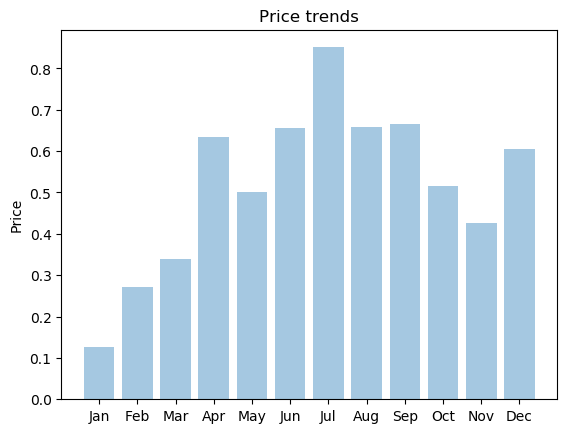

In [782]:
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
months_pos = np.arange(len(months))

plt.bar(months_pos, prices, align='center', alpha=0.4)
plt.xticks(months_pos, months)
plt.ylabel('Price')
plt.title('Price trends')

plt.show()

### Question: What are the 3 most expensive and least expensive neighbourhoods in Seattle for renting?

Here I'll run an analysis to find out the 3 most expensive and least expensive neighborhoods in Seattle. For pricing I'm using price per accommodation, as already calculated above.
<br><br>
First let's take a peek at the neighborhoods.

In [891]:
listings_df['neighbourhood'].value_counts()

Capitol Hill                 351
Ballard                      213
Belltown                     204
Minor                        192
Queen Anne                   187
Fremont                      148
Wallingford                  143
University District          107
First Hill                   105
Stevens                       98
North Beacon Hill             95
Lower Queen Anne              83
Central Business District     81
Greenwood                     79
Columbia City                 61
Ravenna                       59
Phinney Ridge                 56
Magnolia                      55
Green Lake                    52
Atlantic                      50
North Admiral                 48
Mount Baker                   46
Leschi                        44
Eastlake                      41
Maple Leaf                    41
Madrona                       40
Pike Place Market             39
The Junction                  36
Bryant                        32
Seward Park                   32
          

We will ignore neighborhoods, that have less than 10 listings, in order to save the analysis from biases. We are restricted by data here, Airbnb only provides data for 2016. If we had enough data, we wouldn't have dropped any neighborhoods from our analysis.

In [914]:
# drop listings that don't have neighborhood information
neighborhood_df = listings_df.dropna(subset=['neighbourhood'])

neighborhood_series = neighborhood_df['neighbourhood'].value_counts()
neighborhoods = list(neighborhood_series.where(neighborhood_series >= 10).dropna().index)

Variable 'neighborhoods' is a list of all neighborhoods that have at least 10 listings. We'll run the analysis on this these neighborhoods only. We'll create a list of tuples. Each tuple will hold 1) neighborhood name and 2) its mean price per accommodation. After populating the list we can look at the top 3, for least expensive, and bottom 3, for most expensive.

In [920]:
neighborhood_prices = []

for neighborhood in neighborhoods:
    mean_price = neighborhood_df[neighborhood_df['neighbourhood'] == neighborhood]['price_per_accommodation'].mean()
    neighborhood_prices.append((neighborhood, mean_price))

# sort neighborhoods by price per accommodation (low to high)
neighborhood_prices.sort(key=lambda tup: tup[1])

print('Most expensive neighborhoods', neighborhood_prices[-3:])
print('Least expensive neighborhoods', neighborhood_prices[:3])

Most expensive neighborhoods [('Lower Queen Anne', 55.61465863453815), ('Westlake', 62.572916666666664), ('Pioneer Square', 66.90833333333333)]
Least expensive neighborhoods [('Haller Lake', 26.139880952380956), ('Seward Park', 26.641815476190477), ('Rainier Beach', 28.011243386243386)]


Most expensive neighborhoods (price high to low):
- Pioneer Square
- Westlake
- Lower Queen Anne

Least expensive neighborhoods (price low to high):
- Haller Lake
- Seward Park
- Rainier Beach